In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
sys.path.append('.')

from poseestimation import model

pe = model.PoseEstimator()

img_path = './julian.JPG'

I = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

I_list = np.array([I, I])
print(I_list.shape)

peaks = pe.predict(I)

Using TensorFlow backend.
/home/julian/anaconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


(2, 1000, 750, 3)


In [3]:
peaks

[[(381, 144, 0.21996733112609945, 0)],
 [(315, 234, 0.18428639401463442, 1)],
 [(367, 235, 0.12578674640099052, 2)],
 [],
 [],
 [(251, 233, 0.16022761183558032, 3)],
 [],
 [(256, 637, 0.12336413181037642, 4), (257, 638, 0.12364776199683547, 5)],
 [],
 [],
 [],
 [],
 [],
 [],
 [(383, 128, 0.11759853972762357, 6)],
 [(358, 124, 0.24776566125365207, 7)],
 [],
 [(325, 124, 0.14618762191093992, 8)]]

In [13]:
import math
mid_num = 10
paf_avg = np.squeeze(pafs)
h,w,_ = I.shape
thre2 = 0.05
special_k = []
connection_all = []

limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]

mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]

for k in range(len(mapIdx)):
    stuff = [x-19 for x in mapIdx[k]]
    score_mid = paf_avg[:,:,[x-19 for x in mapIdx[k]]]
    candA = peaks[limbSeq[k][0]-1]
    candB = peaks[limbSeq[k][1]-1]
    indexA, indexB = limbSeq[k]
    nA = len(candA); nB = len(candB)
    
    print('A:',candA)
    print('B:',candB)
    
    break
    
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)
                
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])
                
                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*h/norm-1, 0)
                criterion1 = len(np.nonzero(score_midpts > thre2)[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])
                
                
        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)   
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])
    #break

            
print(connection_all)

A: [(315, 234, 0.18428639401463442, 1)]
B: [(367, 235, 0.12578674640099052, 2)]
[]


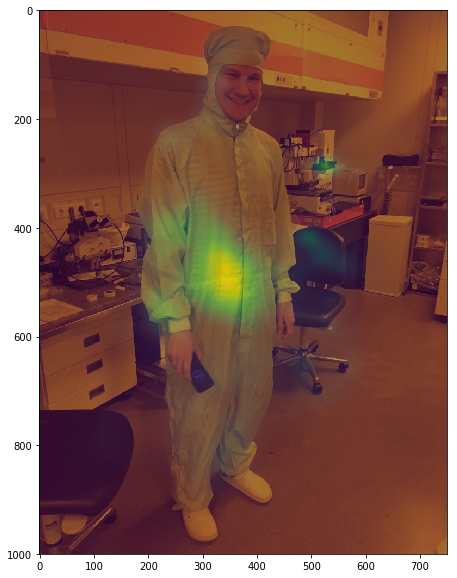

In [16]:
heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)

one = np.squeeze(heatmaps[:,:,:,8])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(I)
ax.imshow(one, alpha=0.5)
plt.show()